In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math

In [27]:
time_1yr = '8736.0' #no. of hours in a year
#the sigma values of the susceptibility log norm distbs
#used for file identification
sigma99 = '0.56003'
sigma98 = '0.66599'
sigma97 = '0.76487'
sigma96 = '0.87160'
sigma95 = '1.00180'
sigma94 = '1.20080'
sigma93 = '1.51389'

pc_sigma_pair_99 = (99, sigma99)
pc_sigma_pair_98 = (98, sigma98)
pc_sigma_pair_97 = (97, sigma97)
pc_sigma_pair_96 = (96, sigma96)
pc_sigma_pair_95 = (95, sigma95)
pc_sigma_pair_94 = (94, sigma94)
pc_sigma_pair_93 = (93, sigma93)

pc_res_list = [1, 2, 3, 4, 5, 6, 7] #percentages of the pops which are resistant

dates = ['15-June-2020', '17-June-2020']

In [36]:
def readInData(date, pc_sigma_pair):
    '''this method will return a dataframe from the data.
    making this method to also trim whitespace from the column headers'''
    data = pd.read_csv('data/'+date+'/multispecies-t=8736.0-parallel-event_counters_sigma='+str(pc_sigma_pair[1])+'.txt', index_col=0)
    data.columns = data.columns.str.strip() #removes whitespace from the column headers 
    return data

def readInSeveralData(dates, pc_sigma_pair):
    '''this method is used to read in several datasets and append them all together'''
    data = pd.read_csv('data/'+dates[0]+'/multispecies-t=8736.0-parallel-event_counters_sigma='+str(pc_sigma_pair[1])+'.txt', index_col=0)
    
    for date in dates[1:]:
        data = data.append(pd.read_csv('data/'+date+'/multispecies-t=8736.0-parallel-event_counters_sigma='+str(pc_sigma_pair[1])+'.txt', index_col=0), ignore_index=True)
        
    data.columns = data.columns.str.strip() #removes whitespace from the column headers 
    return data

In [37]:
data99 = readInSeveralData(dates, pc_sigma_pair_99)
data98 = readInSeveralData(dates, pc_sigma_pair_98)
data97 = readInSeveralData(dates, pc_sigma_pair_97)
data96 = readInSeveralData(dates, pc_sigma_pair_96)
data95 = readInSeveralData(dates, pc_sigma_pair_95)
data94 = readInSeveralData(dates, pc_sigma_pair_94)
data93 = readInSeveralData(dates, pc_sigma_pair_93)


In [38]:
ttf_99 = data99['failure time']
ttf_98 = data98['failure time']
ttf_97 = data97['failure time']
ttf_96 = data96['failure time']
ttf_95 = data95['failure time']
ttf_94 = data94['failure time']
ttf_93 = data93['failure time']
collated_ttfs = [ttf_99, ttf_98, ttf_97, ttf_96, ttf_95, ttf_94, ttf_93]

In [39]:
def survival_probability(ttf_list):
    '''this method takes in a dataframe and returns a list of the survival probability over time
    returns a list of times, the survival probabilities at those times, and the associated errors'''
    
    histo, bin_edges = np.histogram(ttf_list, bins=100, range=(0, float(time_1yr))) #histogram the failure times
    n_vals = len(ttf_list.index) #get number of runs
    survival_probs = (n_vals-np.cumsum(histo[1:]))/n_vals #get the survival probs (ignoring the 0 bin)
    survival_probs = np.append(1., survival_probs) #add the initial value of 1. for t = 0
    errs = (survival_probs*(1. - survival_probs))/np.sqrt(n_vals)
    #print(n_vals)
    #print(errs)
    return bin_edges[:-1], survival_probs, errs

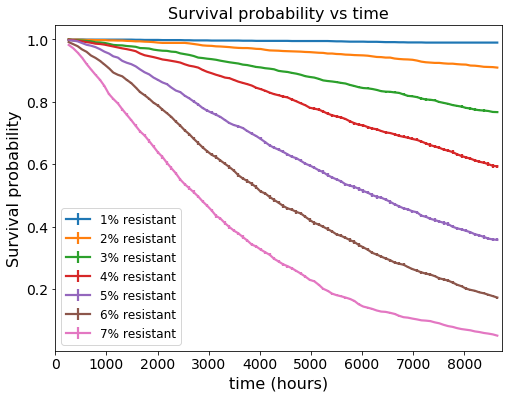

In [40]:
def plot_survival_probs(collated_ttfs):
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    for ttf, pc_r in zip(collated_ttfs, pc_res_list):
        t, surv_prob, errs = survival_probability(ttf)
        ax.errorbar(t[3:], surv_prob[3:], yerr=errs[3:], label=str(pc_r)+'% resistant', lw=2.2)
    
    ax.set_title('Survival probability vs time', fontsize=titleSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.set_ylabel('Survival probability', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    ax.set_xlim(0, float(time_1yr))
    plt.legend(fontsize='large')
    plt.show()

    
plot_survival_probs(collated_ttfs)

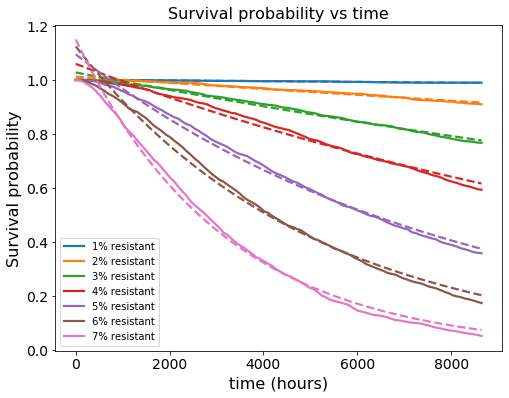

In [41]:
def fit_survival_slope(collated_ttfs):
    '''this function takes in the survival probability data and fits an exponential decay to it.  We can then extract the slope and plot this vs % resistant
    returns a list of tuples.  each tuple contains the % resistance of a population and its associated characteristic failure time tau'''
    
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    
    def func(x, a, b, c):
        #this is the function we're fitting the curves to. here it's an exponential decay with some constants
        #b is the variable of interest we'll be after 
        return a*np.exp(-b*x) + c
        #return a*x + b
        
    pcres_and_tau = [] #this is the list that the percentages and exponential slopes will be saved to
    
    #iterate over the time to failure data and also the values of each percentage resistant
    for ttf, pc_r in zip(collated_ttfs, pc_res_list):
        #extract the survival probs and time data as before
        t, surv_prob, _ = survival_probability(ttf)
        
        popt, pcov = curve_fit(func, t[3:], surv_prob[3:], p0=[1., 1e-7, 1.], bounds=([0., -np.inf, 0.], [2., np.inf, 2.]))
        
        pcres_and_tau.append((pc_r, popt[1]))
        
        color=next(ax._get_lines.prop_cycler)['color']
        ax.plot(t, surv_prob, color=color, lw=2.2, label=str(pc_r)+'% resistant')
        ax.plot(t, func(t, *popt), color=color, ls='--', lw=2.2)#, label=str(pc_r)+'% resistant (fit)')
        
        #print(popt)
        #print(pcov)
        
    ax.set_title('Survival probability vs time', fontsize=titleSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.set_ylabel('Survival probability', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    plt.legend(fontsize='medium')
    plt.savefig('plots/fitted_surv_probs.pdf')
    plt.show()
    
    return pcres_and_tau
        
fitted_slopes = fit_survival_slope(collated_ttfs)        

[82.66644304800661, 9.879959866899485, 3.513817442133395, 1.8229161187622371, 0.9207811782878723, 0.5767043844902724, 0.36011442171372204]


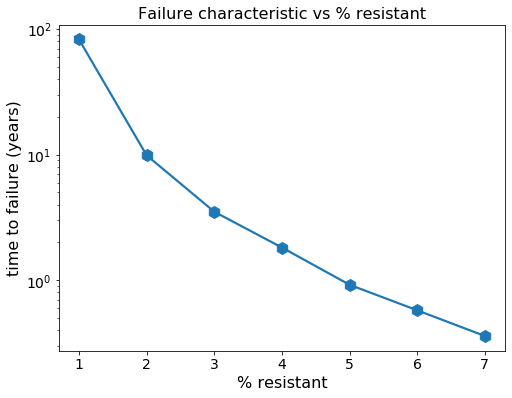

In [44]:
def plot_characteristic_failure_rate(pcres_and_tau):
    
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    pc_res, tau = zip(*pcres_and_tau) #transposes the list to extract the slopes
    tau = [1./(t*24*365) for t in tau] #converts from per hour to per year
    print(tau)
    
    ax.plot(pc_res, tau, marker='h', ms=12, lw=2.2)
    
    ax.set_title('Failure characteristic vs % resistant', fontsize=titleSize)
    ax.set_xlabel('% resistant', fontsize=labelSize)
    ax.set_ylabel('time to failure (years)', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    ax.semilogy()
    plt.savefig('plots/failure_char_vs_pcres.pdf')
    plt.show()
    

plot_characteristic_failure_rate(fitted_slopes)

In [ ]:
# these are the times to failure of the original 1000 runs
#[334.7360447865166, 10.066170896605422, 3.305036072294868, 1.7606842446859723, 0.9050896070507651, 0.5610998433209615, 0.3528684913723677]